In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2
from pathlib import Path


In [2]:

DATA_PATH = Path("/Users/nadaashraf/Heart_Disease_Project/data/cleaned_heart.csv")
assert DATA_PATH.exists(), f"Missing {DATA_PATH}. Run preprocessing first."

df = pd.read_csv(DATA_PATH)
print("Cleaned shape:", df.shape)
df.head()

Cleaned shape: (920, 23)


,id,age,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,dataset_VA Long Beach,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,-1.730169,1.007386,0.705176,0.303643,True,0.489727,False,1.368109,-0.361400,0,...,False,False,False,True,False,False,False,False,False,False
1,-1.726404,1.432034,1.518569,0.789967,False,-1.181478,True,0.611589,4.411152,2,...,False,False,False,False,False,False,True,False,True,False
2,-1.722639,1.432034,-0.650479,0.266939,False,-0.345875,True,1.651804,2.820301,1,...,False,False,False,False,False,False,True,False,False,True
3,-1.718873,-1.752828,-0.108217,0.459634,False,1.961979,False,2.502889,-0.361400,0,...,False,False,True,False,True,False,False,False,True,False
4,-1.715108,-1.328180,-0.108217,0.037541,False,1.365120,False,0.517024,-0.361400,0,...,False,True,False,False,False,False,False,True,True,False


In [3]:
X = df.drop("num", axis=1)
y = df["num"]


In [5]:
 #Feature Importance using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)




/var/folders/1b/267rt42x4q944239m9kb988h0000gn/T/ipykernel_32555/938213956.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15), palette="viridis")


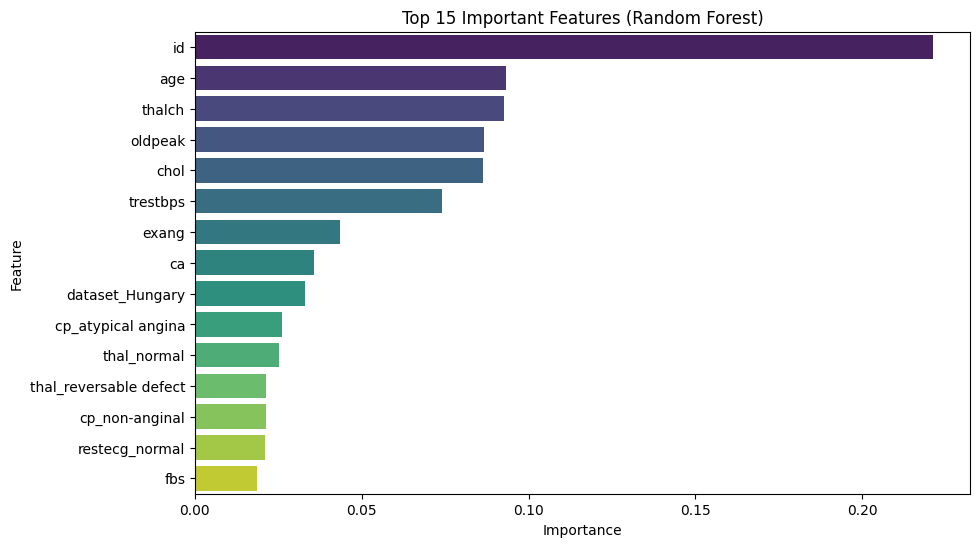

Top 10 Features (Random Forest):
                Feature  Importance
0                   id    0.221165
1                  age    0.093070
5               thalch    0.092733
7              oldpeak    0.086595
3                 chol    0.086382
2             trestbps    0.073960
6                exang    0.043520
8                   ca    0.035691
10     dataset_Hungary    0.033079
13  cp_atypical angina    0.025968


In [8]:
#Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15), palette="viridis")
plt.title("Top 15 Important Features (Random Forest)")
plt.show()
print("Top 10 Features (Random Forest):\n", feat_imp.head(10))

In [9]:
#Recursive Feature Elimination (RFE) with Logistic Regression
model = LogisticRegression(max_iter=2000, solver="liblinear")
rfe = RFE(model, n_features_to_select=10)   # select top 10 predictors
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]
print("\nSelected Features by RFE:\n", selected_features_rfe)


Selected Features by RFE:
 Index(['id', 'exang', 'sex_Male', 'dataset_Hungary', 'dataset_Switzerland',
       'dataset_VA Long Beach', 'cp_atypical angina', 'cp_non-anginal',
       'cp_typical angina', 'thal_normal'],
      dtype='object')


/Users/nadaashraf/Heart_Disease_Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/nadaashraf/Heart_Disease_Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/nadaashraf/Heart_Disease_Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification i

In [10]:
# Chi-Square Test (for categorical relevance)
chi_selector = SelectKBest(score_func=chi2, k=10)
X_chi = chi_selector.fit_transform(abs(X), y)  # abs() to avoid negatives from scaling
chi_features = X.columns[chi_selector.get_support()]
print("\nTop Features by Chi-Square Test:\n", chi_features)


Top Features by Chi-Square Test:
 Index(['chol', 'exang', 'oldpeak', 'ca', 'dataset_Hungary',
       'dataset_Switzerland', 'dataset_VA Long Beach', 'cp_atypical angina',
       'cp_non-anginal', 'thal_reversable defect'],
      dtype='object')


In [12]:
# Final Selected Features (RFE and Chi Square)
final_features = set(selected_features_rfe).union(set(chi_features)).union(set(feat_imp.head(10)["Feature"]))
print("\n Final Selected Features for Modeling:\n", final_features)



 Final Selected Features for Modeling:
 {'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'trestbps', 'id', 'cp_non-anginal', 'exang', 'sex_Male', 'thal_reversable defect', 'thal_normal', 'cp_typical angina', 'ca', 'chol', 'oldpeak', 'thalch', 'age', 'cp_atypical angina'}


In [13]:
# Remove 'id' 
if "id" in final_features:
    final_features.remove("id")
print(final_features)

{'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'trestbps', 'cp_non-anginal', 'exang', 'sex_Male', 'thal_reversable defect', 'thal_normal', 'cp_typical angina', 'ca', 'chol', 'oldpeak', 'thalch', 'age', 'cp_atypical angina'}


the features (dataset_Hungary, dataset_Switzerland, dataset_VA Long Beach)

These don’t describe the patient’s health, they describe where the data came from.

If we included them, then the model may learn dataset quirks (like Hungary patients being older, Switzerland patients having more cholesterol, etc.).

That can artificially improve accuracy but reduce generalization which may lead to unnessecary overfit.

therefore, we will remove these features.

In [ ]:
# Columns that may cause overfit
dataset_cols = {"dataset_Hungary", "dataset_Switzerland", "dataset_VA Long Beach"}

# removing them
final_features_clean = [f for f in final_features if f not in dataset_cols]

print("Final Medical-Only Features:")
print(final_features_clean)


df_selected_clean = df[final_features_clean + ["num"]]
print("Reduced shape:", df_selected_clean.shape)

# reduced dataset
OUT_PATH = Path("/Users/nadaashraf/Heart_Disease_Project/data/heart_selected_features.csv")
df_selected_clean.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH.resolve())


Final Medical-Only Features:
['trestbps', 'cp_non-anginal', 'exang', 'sex_Male', 'thal_reversable defect', 'thal_normal', 'cp_typical angina', 'ca', 'chol', 'oldpeak', 'thalch', 'age', 'cp_atypical angina']
Reduced shape: (920, 14)
Saved: /Users/nadaashraf/Heart_Disease_Project/data/heart_selected_features.csv
